In [106]:
import numpy as np
import polars as pl
import pandas as pd
import json
from datetime import datetime

In [94]:
from collections import UserList
class MsgReport(UserList):
    def __init__(self, report_desription=''):
        self.description = report_desription
        super().__init__()
    def show(self):
        self.show_header()
        for msg in self.data:
            self.show_msg(msg)
        self.show_footer()
    def show_msg(self, msg):
        print(msg)
    def show_header(self):
        print(self.description)
    def show_footer(self):
        pass

In [385]:

#set up the parser 
from ardupilot_log_reader import Ardupilot 
using_fields = [
    "AHR2", # Roll, Pitch, Yaw, Alt, Lat, Lng
    "ATT", # Simulation's roll/pitch/yaw
    "BARO", # Alt/SAML Alt Healt
    "BAT", # Gathered battery data
    "CMD", # command lat/lng/alt
    "CTUN", # desired-achieved-barometric-terrain alt
    "ERR", # errors messages
    "EV", # coded event messages
    "FNCE", # lat, lng
    "GPS", # gps status, NSats, Lat, Lng, Alt, Spd, VericalSpd
    "MCU", # MCU voltage and temperature
    "MODE", # vehical control mode
    "MOTB", # motor batVolt,
    "MSG", # message text
    "ORGN", # lat, lng, alt
    "PM", # autopilot system perfomance and gereral data 
    "POS", # lat, lng, alt, relhome alt, relorigin alt
    "POWR", # system power information
    "RATE", # desired and acvieved vehicle attitude rates
    "TERR", # terrain lat, lng, status
    "XKF1", # RPY
    "XKF4", # filtered error in roll/pitch estimate, filtered data GPS/fault,
    'PIDE', #Proportional/Integral/Derivative gain values for East/West velocity
]





In [386]:
class AnomalyDetector1D:
    def __init__(self, slow_n, quick_n, rel_threshold, abs_threshold):
        self.slow_n = slow_n
        self.quick_n = quick_n
        self.rel_threshold = rel_threshold
        self.abs_threshold = abs_threshold
    def detect(self, series: pd.Series):
        slow_part = self.slow_filter(series)
        quick_part = self.quick_filter(series)

        slow_quick_diff = (slow_part - quick_part).abs()
        rel_diff = slow_quick_diff / (quick_part + 1e-6)

        decision = (rel_diff > self.rel_threshold) & (slow_quick_diff > self.abs_threshold)
        decision_change = decision.astype(int).diff().fillna(0)
        df = pd.DataFrame({'value': series, 'slow_part': slow_part, 'quick_part': quick_part, 'abs_diff': slow_quick_diff, 'rel_diff': rel_diff, 'decision':decision,
                             'decision_change':decision_change})
        return df
    def slow_filter(self, series: pd.Series):
        return self.rolling_mean(series, self.slow_n) 
    def quick_filter(self, series: pd.Series):
        return self.rolling_mean(series, self.quick_n)
    def rolling_mean(self, series:pd.Series, n):
        return series.rolling(n, min_periods=1).mean()
class AnomalyDiffDetector1D(AnomalyDetector1D):
    def detect(self, series: pd.Series):
        diff = series.diff()
        return super().detect(diff)

class AnomalyGrouper:
    def transform(self, anomalies_df):
        
        df = anomalies_df.reset_index()
        df = df.where(df.RemPctChange != 0).dropna()
        #print(df)
        #df['prev_change_id'] = df['index'].shift(-1)
        #df['change_id'] = df.apply(lambda x: x.index if x.RemPctChange == 1 else x.prev_change_id, axis=1)
        df['change_id'] = (df['RemPctChange'] == 1).cumsum()

        #print(df)
        anomaly_intervals = df.groupby('change_id').agg(
            RemPctFrom=('timestamp',min),RemPctTo=('timestamp',max),
            RemPctFirst=('RemPct','first'),RemPctLast=('RemPct','last'))
        anomaly_intervals['RemPctChange'] = anomaly_intervals['RemPctLast'] - anomaly_intervals['RemPctFirst']
        return anomaly_intervals

In [387]:
import matplotlib.pyplot as plt
import pandas as pd


class BattPlot:
    def __init__(self, time_col, value_col, title, label_fmt, anomaly_detector=None):
        self.time_col = time_col
        self.value_col = value_col
        self.label_fmt = label_fmt
        self.title = title
        self.anomaly_detector = anomaly_detector
            
    def plot_instance(self, data, label):
        x = data[self.time_col]
        y = data[self.value_col]
        plt.plot(x, y, label=label)
    def plot(self, data):
        fig = plt.figure()
        plt.suptitle(self.title)
        for instance in data['Instance'].unique():
            instance_data = data[data.Instance == instance]
            if self.anomaly_detector is not None:
                detection = self.anomaly_detector.detect(instance_data['RemPct'])

                anomalies = AnomalyGrouper().transform(instance_data.join(detection['decision_change'].rename('RemPctChange'))).sort_values('RemPctFrom')    
                for i, anom in anomalies.iterrows():
                    plt.plot([anom['RemPctFrom'], anom['RemPctFrom']], [0,100])
            legend = self.label_fmt.format(instance)
            fig = self.plot_instance(instance_data, legend)
        plt.legend()


class BatteryStats(pd.DataFrame):
    def __init__(self, data):
        
        data = self.preproc(data)

        super().__init__(data)
    
    def preproc(self, data):
        # что-то сделать с временем, пересчитать в читаемые даты, пока не понял как
        data['timestamp'] = data['timestamp'].apply(datetime.fromtimestamp)
        return data
    def get_stats(self):
        stats = self \
                .sort_values('timestamp') \
                .groupby('Instance', sort=True) \
            .agg(start_bat=('RemPct', 'first'), end_bat=('RemPct', 'last'), 
                 mean_kw=('EnrgTot', 'mean'), max_kw=('EnrgTot', 'max'), min_kw=('EnrgTot', 'min')) \
            .reset_index()
        return stats
    def get_battery_log(self, instance):
        return self.where(self.Instance == instance).dropna()
    def plot_vs_time(self, value_col, title, label_fmt, anomaly_detector=None):

        return BattPlot('timestamp', value_col, title, label_fmt, anomaly_detector).plot(self)




In [435]:
from datetime import datetime

parser = Ardupilot.parse( 'Logs/log_8_2024-4-24-15-50-58.bin',types =using_fields) # fields to read from the log )

bat_ds = BatteryStats(parser.dfs['BAT'])


/var/folders/9m/s1c10r5937z5zfl9b813zcz40000gp/T/ipykernel_91973/1412987708.py:41: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  anomaly_intervals = df.groupby('change_id').agg(
/var/folders/9m/s1c10r5937z5zfl9b813zcz40000gp/T/ipykernel_91973/1412987708.py:41: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  anomaly_intervals = df.groupby('change_id').agg(
/var/folders/9m/s1c10r5937z5zfl9b813zcz40000gp/T/ipykernel_91973/1412987708.py:41: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep curr

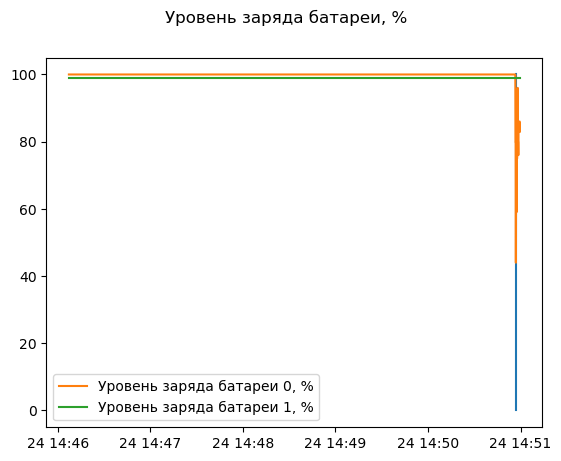

In [436]:
time_gap_detector = AnomalyDetector1D(1000,20, 0.1, 7)
bat_ds.plot_vs_time('RemPct', 'Уровень заряда батареи, %', 'Уровень заряда батареи {}, %', time_gap_detector)

In [ ]:


time_gap_detector = AnomalyDiffDetector1D(100,10, 0.05, 1)
bat0_log = bat_ds.get_battery_log(0)

detection = time_gap_detector.detect(bat0_log['RemPct'])

anomalies = AnomalyGrouper().transform(bat0_log.join(detection['decision_change'].rename('RemPctChange'))).sort_values('RemPctFrom')
anomalies

/var/folders/9m/s1c10r5937z5zfl9b813zcz40000gp/T/ipykernel_91973/1018461661.py:41: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  anomaly_intervals = df.groupby('change_id').agg(
/var/folders/9m/s1c10r5937z5zfl9b813zcz40000gp/T/ipykernel_91973/1018461661.py:41: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  anomaly_intervals = df.groupby('change_id').agg(


In [99]:
class BatteryStatMessage:
    _format = "Батарея №: {instance:.0f}, Заряд на старте,%: {start_bat}, Заряд в конце,%: {end_bat}, Средняя потребл. мощность, КВт: {mean_kw}"
    def __init__(self, data_tuple):
        self.instance, self.start_bat, self.end_bat, self.mean_kw, self.max_kw, self.min_kw = data_tuple
    def __str__(self):
        # Преобразование timestamp в читаемый формат даты и времени
        
        return self._format.format(
            instance=self.instance,
            start_bat=self.start_bat,
            end_bat=self.end_bat,
            mean_kw=self.mean_kw
        )

battery_report = MsgReport()
battery_info = bat_ds.get_stats().sort_values('Instance')    
for i, bat_stat in battery_info.iterrows():
    battery_report.append(BatteryStatMessage(bat_stat))
battery_report.show()



Батарея №: 0, Заряд на старте,%: 100.0, Заряд в конце,%: 34.0, Средняя потребл. мощность, КВт: 13.616861151461912
Батарея №: 1, Заряд на старте,%: 99.0, Заряд в конце,%: 58.0, Средняя потребл. мощность, КВт: 90.77404712128336


In [92]:
from datetime import datetime
from collections import UserList

with open('err_codes.json')as f:
    ERRROR_DESCRIPTIONS = pd.DataFrame(json.load(f))
ERRROR_DESCRIPTIONS


class ErrorMessage:
    _format = "Time: {time}, Subsystem Code: {subsys_code}, Subsystem Name: {subsys_name}, Description: {description}"

    def __init__(self, data_tuple):
        self.timestamp, self.TimeUS, self.Subsys, self.ECode, self.subsys_name, self.description = data_tuple

    def __str__(self):
        # Преобразование timestamp в читаемый формат даты и времени
        time_str = datetime.fromtimestamp(self.timestamp).strftime('%Y-%m-%d %H:%M:%S')
        
        return self._format.format(
            time=time_str,
            subsys_code=self.Subsys,
            subsys_name=self.subsys_name,
            description=self.description
        )

msg_log = parser.dfs['ERR'].merge(ERRROR_DESCRIPTIONS, on='Subsys ECode'.split())

msg_log = msg_log.sort_values('timestamp')
err_report = MsgReport()

for i, msg in msg_log.iterrows():
    err_report.append(ErrorMessage(msg))
err_report.show()


Time: 2024-04-23 08:56:18, Subsystem Code: 2, Subsystem Name: Radio, Description: Late Frame : no updates received from receiver for two seconds
Time: 2024-04-23 08:56:18, Subsystem Code: 5, Subsystem Name: Radio Failsafe, Description: Failsafe Triggered
Time: 2024-04-23 08:56:26, Subsystem Code: 5, Subsystem Name: Radio Failsafe, Description: Failsafe Resolved
Time: 2024-04-23 08:57:05, Subsystem Code: 2, Subsystem Name: Radio, Description: Late Frame : no updates received from receiver for two seconds
Time: 2024-04-23 08:57:05, Subsystem Code: 5, Subsystem Name: Radio Failsafe, Description: Failsafe Triggered
Time: 2024-04-23 09:06:15, Subsystem Code: 5, Subsystem Name: Radio Failsafe, Description: Failsafe Resolved
Time: 2024-04-23 09:13:17, Subsystem Code: 2, Subsystem Name: Radio, Description: Late Frame : no updates received from receiver for two seconds
Time: 2024-04-23 09:13:17, Subsystem Code: 5, Subsystem Name: Radio Failsafe, Description: Failsafe Triggered


In [66]:
with open('mode_codes.json') as f: 
  MESSAGE_DESCRIPTIONS = pd.DataFrame(json.load(f))


class ModeMessage:
    _format = "Time: {time}, Mode: {Mode}, Reason: {Reason}, Description: {description}"

    def __init__(self, data_tuple):
        self.timestamp, self.TimeUS, self.Mode, self.ModeNum, self.Rsn, self.message = data_tuple

    def __str__(self):
        # Преобразование timestamp в читаемый формат даты и времени
        time_str = datetime.fromtimestamp(self.timestamp).strftime('%Y-%m-%d %H:%M:%S')
        
        return self._format.format(
            time=time_str,
            Mode=self.Mode,
            Reason=self.Rsn,
            description=self.message
        )



msg_log = parser.dfs['MODE'].merge(MESSAGE_DESCRIPTIONS, on='Rsn')
msg_log = msg_log.sort_values('timestamp')

mode_report = MsgReport()
for i, msg in msg_log.iterrows():
  mode_report.append(ModeMessage(msg))
mode_report.show()

Time: 2024-04-23 08:33:47, Mode: 0, Reason: 26, Description: INITIALISED
Time: 2024-04-23 08:47:54, Mode: 2, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:51:44, Mode: 5, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:53:01, Mode: 2, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:55:00, Mode: 5, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:55:04, Mode: 2, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:55:46, Mode: 5, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:55:49, Mode: 2, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:55:52, Mode: 0, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:55:56, Mode: 2, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:55:56, Mode: 5, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:55:58, Mode: 3, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:56:00, Mode: 5, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:56:10, Mode: 0, Reason: 1, Description: RC_COMMAND
Time

In [79]:
with open('ev_codes.json') as f: 
  EV_CODES = pd.DataFrame(json.load(f)) \
    .rename({'value':'Id'}, axis=1)


class EvMessage:
    _format = "Time: {time}, Id: {Id}, Message: {Message}"

    def __init__(self, data_tuple):
        self.timestamp, self.TimeUS, self.Id, self.Message = data_tuple

    def __str__(self):
        # Преобразование timestamp в читаемый формат даты и времени
        time_str = datetime.fromtimestamp(self.timestamp).strftime('%Y-%m-%d %H:%M:%S')
        
        return self._format.format(
            time=time_str,
            Id=self.Id,
            Message=self.Message
        )



msg_log = parser.dfs['EV'].merge(EV_CODES, on='Id')
msg_log = msg_log.sort_values('timestamp')

ev_report = MsgReport()
for i, msg in msg_log.iterrows():
  ev_report.append(EvMessage(msg))
ev_report.show()


Time: 2024-04-23 08:33:47, Id: 56, Message: MOTORS_INTERLOCK_DISABLED
Time: 2024-04-23 08:33:58, Id: 56, Message: MOTORS_INTERLOCK_DISABLED
Time: 2024-04-23 08:34:11, Id: 56, Message: MOTORS_INTERLOCK_DISABLED
Time: 2024-04-23 08:34:25, Id: 56, Message: MOTORS_INTERLOCK_DISABLED
Time: 2024-04-23 08:47:56, Id: 57, Message: MOTORS_INTERLOCK_ENABLED
Time: 2024-04-23 08:48:00, Id: 15, Message: AUTO_ARMED
Time: 2024-04-23 08:48:23, Id: 28, Message: NOT_LANDED
Time: 2024-04-23 08:48:33, Id: 17, Message: LAND_COMPLETE_MAYBE
Time: 2024-04-23 08:48:34, Id: 18, Message: LAND_COMPLETE
Time: 2024-04-23 08:48:43, Id: 28, Message: NOT_LANDED
Time: 2024-04-23 08:54:36, Id: 17, Message: LAND_COMPLETE_MAYBE
Time: 2024-04-23 08:54:36, Id: 18, Message: LAND_COMPLETE
Time: 2024-04-23 08:54:39, Id: 11, Message: DISARMED
Time: 2024-04-23 08:54:39, Id: 56, Message: MOTORS_INTERLOCK_DISABLED
Time: 2024-04-23 08:55:58, Id: 15, Message: AUTO_ARMED
Time: 2024-04-23 08:55:58, Id: 15, Message: AUTO_ARMED
Time: 20